### Fine Tuning Model for Classification Task

We will be using Airline Sentiment Data available under following link: 
https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment?select=Tweets.csv

#### What is fine-tuning in transformers?
* Fine-tuning is a process in which a pre-trained model is further trained on a new task using task-specific data. 

* In the context of Transformer models, fine-tuning refers to the process of using a pre-trained Transformer model as the starting point for training on a new task.

* The idea behind fine-tuning Transformer models is that they have already been trained on a large corpus of text data, and therefore have already learned many useful representations of language. By fine-tuning the model on a new task, the model can use these pre-learned representations as a good starting point, and learn task-specific information from the new task data.


### General Process Roadmap of Fine-Tuning models?
Fine-tuning a Transformer model for a specific task typically involves the following steps:

* Prepare the task-specific data
* Tokenize the data
* Choose a pre-trained model
* Define a fine-tuning architecture
* Compile the model
* Train the model
* Evaluate the model

In [ ]:
#!pip install transformers

In [1]:
import pandas as pd
import numpy as np

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('Tweets.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [4]:
df = df[['airline_sentiment','text']]

In [5]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<Axes: >

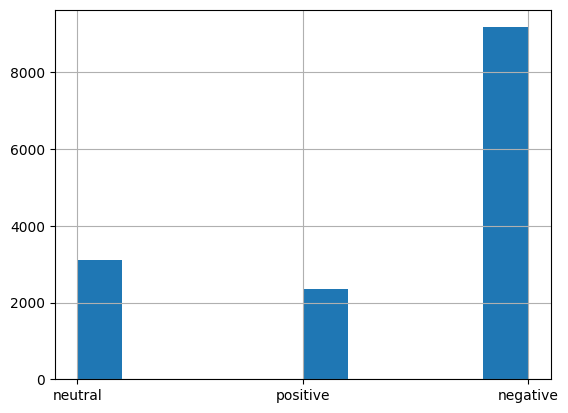

In [6]:
df['airline_sentiment'].hist()

In [7]:
target_map = { 'positive': 1, 'negative': 0, 'neutral': 2}
df['target'] = df['airline_sentiment'].map(target_map)

In [8]:
df1 = df[['text','target']]
df1.columns = ['sentence','label']
df1.to_csv('data.csv', index = False)

In [9]:
!pip install datasets

In [10]:
from datasets import load_dataset
raw_dataset = load_dataset('csv', data_files = 'data.csv')

C:\Users\mukul\anaconda3\envs\notebook\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 14640 examples [00:00, 111399.26 examples/s]


In [11]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [12]:
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)

In [13]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

### Tokenization

Convert the task-specific data into a numerical representation suitable for input into the Transformer model. This typically involves tokenizing the text into subwords or words, mapping the tokens to integers, and encoding the input as a tensor.

* The code is using the AutoTokenizer class from the transformers library to load a pre-trained tokenizer for the BERT model with the "base" architecture version. 
* The pre-trained tokenizer will be used to convert input sequences of text into numerical representations (tokens) that can be fed into the model. 
* The checkpoint variable specifies the name of the pre-trained tokenizer to use, and the from_pretrained method is used to load the tokenizer from the transformers library's pre-trained models.

In [14]:
# Import AutoTokenizer and create tokenizer object
from transformers import AutoTokenizer
checkpoint = 'bert-base-cased'
tokernizer = AutoTokenizer.from_pretrained(checkpoint)

C:\Users\mukul\anaconda3\envs\notebook\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mukul\.cache\huggingface\hub\models--bert-base-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Note: The “batch” argument is expected to be a dictionary-like object that contains the text data to be tokenized.

In [15]:
def tokenize_fn(batch):
  return tokernizer(batch['sentence'], truncation = True)

In [ ]:
tokenized_dataset = split.map(tokenize_fn, batched = True)

In [17]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

### About the Models

* **AutoModelForSequenceClassification** facilitates the implementation of sequence classification models, enabling the prediction of class labels for input sequences like sentences, with the AutoModel architecture selecting the most appropriate model for the task and data.

* **Trainer and TrainingArguments** provide a streamlined approach for training machine learning models, offering high-level APIs to manage training runs and configure key parameters such as batch size, learning rate, and training steps, essential for efficient model training and optimization.

In [18]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
!pip install torchinfo

In [20]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           2,307
Total params: 10

In [21]:
training_args = TrainingArguments(output_dir='training_dir',
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  num_train_epochs=3,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=64,
                                  )

In [22]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average = 'micro')
  return {'accuracy': acc, 'f1_score': f1}

In [23]:
trainer = Trainer(model,
                  training_args,
                  train_dataset = tokenized_dataset["train"],
                  eval_dataset = tokenized_dataset["test"],
                  tokenizer=tokernizer,
                  compute_metrics=compute_metrics)

C:\Users\mukul\anaconda3\envs\notebook\lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss


Conclusion: As we have set 3 epochs, we have got 3 evaluation metrics. Notice our model is overfitting as validation loss is increases for each epochs. So one epoch will be sufficient for this dataset as we are getting 83% accuracy as well as f1 score.

In [25]:
!ls training_dir

# Models Generated - checkpoint-1282

'ls' is not recognized as an internal or external command,
operable program or batch file.


Now we will be using our first model to do the predictions. 

In [26]:
# Now we will use the saved model to do the text classification
from transformers import pipeline
saved_model = pipeline('text-classification',
                       model = 'training_dir/checkpoint-1282') 

# Note we are using the first model : checkpoint-1282

In [27]:
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 4392
})

In [28]:
prediction = saved_model(split['test']['sentence'])

In [29]:
prediction[:10]

[{'label': 'LABEL_1', 'score': 0.9279263019561768},
 {'label': 'LABEL_1', 'score': 0.8951221108436584},
 {'label': 'LABEL_1', 'score': 0.6891613006591797},
 {'label': 'LABEL_1', 'score': 0.8085505962371826},
 {'label': 'LABEL_0', 'score': 0.9400619268417358},
 {'label': 'LABEL_0', 'score': 0.9964829683303833},
 {'label': 'LABEL_2', 'score': 0.9132664203643799},
 {'label': 'LABEL_2', 'score': 0.9698492288589478},
 {'label': 'LABEL_2', 'score': 0.6534978747367859},
 {'label': 'LABEL_0', 'score': 0.9977474808692932}]

In [30]:
def get_label(d):
  return int(d['label'].split('_')[1])
predictions = [get_label(d) for d in prediction]

In [31]:
print("acc:",accuracy_score(split['test']['label'], predictions))

acc: 0.8413023679417122


In [32]:
print("f1:",f1_score(split['test']['label'], predictions, average = 'macro'))

f1: 0.7839692180869946


In [33]:
import seaborn as sns

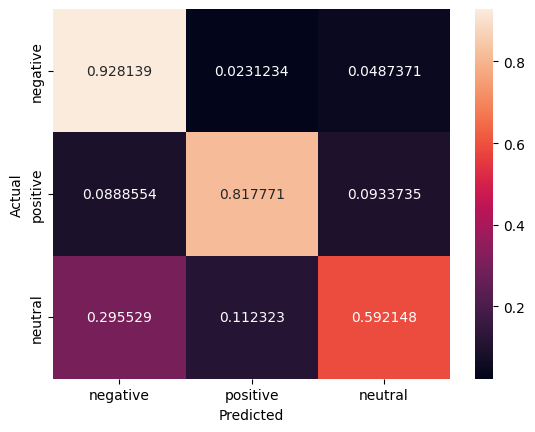

In [34]:
# create function for plotting confusion matrix
def plot_cm(cm):
  classes = ['negative','positive','neutral']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sns.heatmap(df_cm, annot = True, fmt='g')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

cm = confusion_matrix(split['test']['label'],predictions, normalize = 'true')
plot_cm(cm)